# Data Preprocessing for LSTM-RNN

### Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from scipy import stats
from scipy.special import inv_boxcox
import sklearn.metrics as met
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge

import itertools
import multiprocessing
import matplotlib.pyplot as plt

from datetime import datetime

from numpy.linalg import inv
from sklearn.utils import shuffle

import timeit

import tensorflow as tf



In [2]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = False
# #Now when creating your session pass this config to it.
# sess = tf.Session(config=config)

### Import Data

In [3]:
PTNdata1Path = ('/Users/nickcforrest/Documents/My Documents/Education/AFIT/AFIT WORK/Course Work/Thesis Work/Python Files/PTNdata1_clean.csv')
PTNdata1 = pd.read_csv(PTNdata1Path).iloc[0:, 1:]
PTNdata1.head()

,Student ID,Training Date,Flight/Sim #,Mission Analysis/Products,Ground Ops,Takeoff,Departure,Basic Aircraft Control,Cross-Check,Enroute Descent / Recovery,...,Crew Coordination,Single Engine Approach,Single Engine GA/Missed Appch,A/R Overrun,A/R Breakaway,FD/AP Operations,FMS Operations,Device,Training Exercise,Total MIF
0,1,2018-04-02,Sim #2,1.0,2.0,2.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,1,36
1,1,2018-04-03,Sim #3,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,2,49
2,1,2018-04-04,Flight #1,1.0,2.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,3,57
3,1,2018-04-06,Sim #5,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,4,71
4,1,2018-04-06,Sim #1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,5,72


### Make scores a fraction of individual MIF for each maneuver to more appropriately track progress

In [4]:
#list of mifs in order with PTNdata1 column order
maneuverMIF = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,3,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,3,3,4,4,4,4,4,3,4,4,4,3,3,4,4,4,4,4,4,4,3,4,3,3,3,3,4,3]

#make df to reference 
maneuverMIF_df = pd.DataFrame([PTNdata1.iloc[:,3:-3].columns,maneuverMIF])
maneuverMIF_df.columns = maneuverMIF_df.iloc[0]
maneuverMIF_df.drop(maneuverMIF_df.index[0],inplace=True)
#maneuverMIF_df


In [5]:
#convert to dictionary for easy adjustment and checking
maneuverMIF_dict = maneuverMIF_df.to_dict('r')
#maneuverMIF_dict

### Utility Functions

In [6]:
#function to convert nonzero values to 1
def convertBoolean(mylist): 
    return [[1 if m>0 else 0 for m in x] for p,x in enumerate(mylist)]

### Import Deep Learning Packages

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

#additional imports that may be helpful
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers.core import Lambda

Using TensorFlow backend.


### Set Model Parameters

In [8]:
#Set Sequence length. # of previous gradesheet records to incorporate into prediction
seq_length = 50

In [9]:
#set input dim to number of maneuver grades for each vector in series
num_maneuvers = len(maneuverMIF)
b_size = 2 #batch size for training
loss_func = 'binary_crossentropy'
learningRate = 0.0001
opt = Adam(lr=learningRate)
activ = 'relu'
num_epoch = 100 #number of epochs to train for

### Build Training Set

In [10]:
#set aside students 1-4 for testing by establishing training set as everyone else
training_examples = [x for x in PTNdata1['Student ID'].unique() if x>4]
print(training_examples)

#identify training/validaiton data
trainValData = PTNdata1[PTNdata1['Student ID'].isin(training_examples)]

[5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [11]:
lossVec_trn = []
accVec_trn = []
lossVec_val = []
accVec_val = []
leftOut = []

for leaveOut in training_examples:
    
    model = Sequential(name = 'Content-Based LSTM RNN Model')
    model.add(LSTM(100, activation =activ,return_sequences = True, input_shape=(seq_length, num_maneuvers),name = 'LSTM_Layer_1'))
    model.add(LSTM(100,activation = activ,name = "LSTM_Layer_2"))
    model.add(Dense(num_maneuvers,activation = "sigmoid",name="Output_Layer"))
    model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

    indexleaveOut = trainValData[trainValData['Student ID'] == leaveOut].index #set val index

    ##################  TRAINING ########################
    data_frac_trn = trainValData.drop(indexleaveOut) #seperate train from val. 
    data_frac_trn = data_frac_trn.iloc[:,3:-3]/maneuverMIF #convert to fraction over individual mifs
    data_frac_trn = data_frac_trn.replace(np.nan,np.float64(0))
    data_frac_trn.head()

    #create input list of lists containing scores up to and at each particular training Exercise 
    #dont include last record because there is no target variable definable for last record per student
    seq_lst_ins_trn = [data_frac_trn.iloc[0:i].values.tolist() for i in range(1,len(data_frac_trn.index))]

    #pad sequences using pre-sequence truncation
    #when over 50 training Exercises are in memory bank, remove earliest timesteps from the beginning of sequences
    padded_seq_ins_trn = pad_sequences(seq_lst_ins_trn, padding='pre',dtype='float32',maxlen = seq_length)
    #print('shape of inputs',padded_seq_ins_trn.shape)

    #create target for recommendations
    seq_lst_tgt_trn = np.array([data_frac_trn.iloc[i+1] for i in range(0,len(data_frac_trn.index)-1)])
    #print('shape of target',seq_lst_tgt_trn.shape)

    #convert array to list
    seq_lst_tgt_trn = [l.tolist() for l in seq_lst_tgt_trn]

    #convert all maneuvers to perform or not in boolean
    #0 means do not perform
    #1 means perform
    seq_lst_tgt_trn = convertBoolean(seq_lst_tgt_trn)

    #convert back to an array
    seq_lst_tgt_trn = np.asarray(seq_lst_tgt_trn)


    ##################  VALIDATION ########################
    data_frac_val = trainValData[trainValData['Student ID'] == leaveOut].iloc[:,3:-3]/maneuverMIF #seperate train from val and convert to fraction over individual mifs
    data_frac_val = data_frac_val.replace(np.nan,np.float64(0))
    data_frac_val

    #create input list of lists containing scores up to and at each particular training Exercise 
    #dont include last record because there is no target variable definable for last record per student
    seq_lst_ins_val = [data_frac_val.iloc[0:i].values.tolist() for i in range(1,len(data_frac_val.index))]

    #pad sequences using pre-sequence truncation
    #when over 50 training Exercises are in memory bank, remove earliest timesteps from the beginning of sequences
    padded_seq_ins_val = pad_sequences(seq_lst_ins_val, padding='pre',dtype='float32',maxlen = seq_length)
    #print('shape of inputs',padded_seq_ins_val.shape)

    #create target for recommendations
    seq_lst_tgt_val = np.array([data_frac_val.iloc[i+1] for i in range(0,len(data_frac_val.index)-1)])
    #print('shape of target',seq_lst_tgt_val.shape)

    #convert array to list
    seq_lst_tgt_val = [l.tolist() for l in seq_lst_tgt_val]

    #convert all maneuvers to perform or not in boolean
    #0 means do not perform
    #1 means perform
    seq_lst_tgt_val = convertBoolean(seq_lst_tgt_val)

    #convert back to an array
    seq_lst_tgt_val = np.asarray(seq_lst_tgt_val)


    early_stop = EarlyStopping(monitor='val_loss', mode = 'min', min_delta = 0.001,patience=15, verbose=2, restore_best_weights=True) #stop training early if val accuracy is consistently decreasing for 15 epochs
    modCheck = ModelCheckpoint('Model_LOOCV_50.h5', monitor = 'val_loss', mode = 'min',verbose = 2, save_best_only = True) #save only the best weights from training
    hist = model.fit(padded_seq_ins_trn, seq_lst_tgt_trn, epochs=num_epoch, batch_size=b_size, validation_data=(padded_seq_ins_val, seq_lst_tgt_val), verbose=2, shuffle=False,callbacks = [early_stop,modCheck])

    #report training evaluation
    train_eval = model.evaluate(padded_seq_ins_trn,seq_lst_tgt_trn)
    lossVec_trn.append(train_eval[0])
    accVec_trn.append(train_eval[1])

    #report validation evaluation
    val_eval = model.evaluate(padded_seq_ins_val,seq_lst_tgt_val)
    lossVec_val.append(val_eval[0])
    accVec_val.append(val_eval[1])

    #note the specific training environments for results
    leftOut.append(leaveOut)
    


Train on 1076 samples, validate on 89 samples
Epoch 1/100
 - 30s - loss: 0.4008 - accuracy: 0.8626 - val_loss: 0.4544 - val_accuracy: 0.9034

Epoch 00001: val_loss improved from inf to 0.45441, saving model to Model_LOOCV_50.h5
Epoch 2/100
 - 30s - loss: 0.2486 - accuracy: 0.9179 - val_loss: 0.3526 - val_accuracy: 0.9132

Epoch 00002: val_loss improved from 0.45441 to 0.35257, saving model to Model_LOOCV_50.h5
Epoch 3/100
 - 31s - loss: 0.2353 - accuracy: 0.9190 - val_loss: 0.3371 - val_accuracy: 0.9108

Epoch 00003: val_loss improved from 0.35257 to 0.33707, saving model to Model_LOOCV_50.h5
Epoch 4/100
 - 30s - loss: 0.2285 - accuracy: 0.9188 - val_loss: 0.3193 - val_accuracy: 0.9106

Epoch 00004: val_loss improved from 0.33707 to 0.31926, saving model to Model_LOOCV_50.h5
Epoch 5/100
 - 30s - loss: 0.2207 - accuracy: 0.9190 - val_loss: 0.2890 - val_accuracy: 0.9123

Epoch 00005: val_loss improved from 0.31926 to 0.28901, saving model to Model_LOOCV_50.h5
Epoch 6/100
 - 33s - loss: 0

In [12]:
print(lossVec_trn)
print(lossVec_val)
print('')
print(accVec_trn)
print(accVec_val)
print('')
print(leftOut)

import operator
min_index, min_value = min(enumerate(lossVec_val), key=operator.itemgetter(1))
print(leftOut[min_index])
max_index, max_value = max(enumerate(accVec_val), key=operator.itemgetter(1))
print(leftOut[max_index])

[0.18158860654192785, 0.1713934920275409, 0.2001283256542498, 0.19137119646145306, 0.18780423975523625, 0.18056997955963713, 0.18586952784168187, 0.18846587339112925, 0.19427187084932135, 0.18050049178635896, 0.18769787704642815, 0.20711581961675124, 0.19413476663421628, 0.18813913919323666]
[0.2111419512984458, 0.21626364845263807, 0.1898072651203941, 0.2348181335038917, 0.18205108108756307, 0.1731031962265872, 0.18356968061898343, 0.17391615509986877, 0.18819177245037466, 0.18317203784501682, 0.17730877005447776, 0.17865347128648024, 0.23120719131003034, 0.1792111949009054]

[0.9237409830093384, 0.9249252080917358, 0.9208352565765381, 0.920803427696228, 0.9211548566818237, 0.9241396188735962, 0.9220353364944458, 0.9213444590568542, 0.9205225706100464, 0.923653244972229, 0.9213593602180481, 0.9180113673210144, 0.9211455583572388, 0.9219604730606079]
[0.915291428565979, 0.9120846390724182, 0.9206112027168274, 0.9071584343910217, 0.922218382358551, 0.9243213534355164, 0.9225470423698425

### Fit Best Model Based on LOOCV insights

### Define Training and Val Sets

In [13]:
#names to help with interpretation 
# train_X = padded_seq_ins_trn
# train_y = seq_lst_tgt_trn
# val_X = padded_seq_ins_val
# val_y = seq_lst_tgt_val
# test_X = padded_seq_ins_tst
# test_y = seq_lst_tgt_tst

In [14]:

#defining the student to leave out for training of best fit model. 
leaveOut = leftOut[min_index]
print(leaveOut)

indexleaveOut = trainValData[trainValData['Student ID'] == leaveOut].index #set val index

##################  TRAINING ########################
data_frac_trn = trainValData.drop(indexleaveOut) #seperate train from val. 
data_frac_trn = data_frac_trn.iloc[:,3:-3]/maneuverMIF #convert to fraction over individual mifs
data_frac_trn = data_frac_trn.replace(np.nan,np.float64(0))
data_frac_trn.head()

#create input list of lists containing scores up to and at each particular training Exercise 
#dont include last record because there is no target variable definable for last record per student
seq_lst_ins_trn = [data_frac_trn.iloc[0:i].values.tolist() for i in range(1,len(data_frac_trn.index))]

#pad sequences using pre-sequence truncation
#when over 50 training Exercises are in memory bank, remove earliest timesteps from the beginning of sequences
padded_seq_ins_trn = pad_sequences(seq_lst_ins_trn, padding='pre',dtype='float32',maxlen = seq_length)
#print('shape of inputs',padded_seq_ins_trn.shape)

#create target for recommendations
seq_lst_tgt_trn = np.array([data_frac_trn.iloc[i+1] for i in range(0,len(data_frac_trn.index)-1)])
#print('shape of target',seq_lst_tgt_trn.shape)

#convert array to list
seq_lst_tgt_trn = [l.tolist() for l in seq_lst_tgt_trn]

#convert all maneuvers to perform or not in boolean
#0 means do not perform
#1 means perform
seq_lst_tgt_trn = convertBoolean(seq_lst_tgt_trn)

#convert back to an array
seq_lst_tgt_trn = np.asarray(seq_lst_tgt_trn)


##################  VALIDATION ########################
data_frac_val = trainValData[trainValData['Student ID'] == leaveOut].iloc[:,3:-3]/maneuverMIF #seperate train from val and convert to fraction over individual mifs
data_frac_val = data_frac_val.replace(np.nan,np.float64(0))
data_frac_val

#create input list of lists containing scores up to and at each particular training Exercise 
#dont include last record because there is no target variable definable for last record per student
seq_lst_ins_val = [data_frac_val.iloc[0:i].values.tolist() for i in range(1,len(data_frac_val.index))]

#pad sequences using pre-sequence truncation
#when over 50 training Exercises are in memory bank, remove earliest timesteps from the beginning of sequences
padded_seq_ins_val = pad_sequences(seq_lst_ins_val, padding='pre',dtype='float32',maxlen = seq_length)
#print('shape of inputs',padded_seq_ins_val.shape)

#create target for recommendations
seq_lst_tgt_val = np.array([data_frac_val.iloc[i+1] for i in range(0,len(data_frac_val.index)-1)])
#print('shape of target',seq_lst_tgt_val.shape)

#convert array to list
seq_lst_tgt_val = [l.tolist() for l in seq_lst_tgt_val]

#convert all maneuvers to perform or not in boolean
#0 means do not perform
#1 means perform
seq_lst_tgt_val = convertBoolean(seq_lst_tgt_val)

#convert back to an array
seq_lst_tgt_val = np.asarray(seq_lst_tgt_val)

11


### Build LSTM Model
Stacked LSTM for multivariate output time series forecasting.

In [15]:
model = Sequential(name = 'Content-Based LSTM RNN Model')
model.add(LSTM(100, activation =activ,return_sequences = True, input_shape=(seq_length, num_maneuvers),name = 'LSTM_Layer_1'))
model.add(LSTM(100,activation = activ,name = "LSTM_Layer_2"))
model.add(Dense(num_maneuvers,activation = "sigmoid",name="Output_Layer"))
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

In [16]:
model.summary()

Model: "Content-Based LSTM RNN Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 50, 100)           91600     
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 100)               80400     
_________________________________________________________________
Output_Layer (Dense)         (None, 128)               12928     
Total params: 184,928
Trainable params: 184,928
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_layers = len(model.layers[:-1])

In [18]:
# fit final model
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', min_delta = 0.001,patience=15, verbose=2, restore_best_weights=True) #stop training early if val accuracy is consistently decreasing for 15 epochs
modCheck = ModelCheckpoint('Model_LOOCV_50.h5', monitor = 'val_loss', mode = 'min',verbose = 2, save_best_only = True) #save only the best weights from training
hist = model.fit(padded_seq_ins_trn, seq_lst_tgt_trn, epochs=num_epoch, batch_size=b_size, validation_data=(padded_seq_ins_val, seq_lst_tgt_val), verbose=2, shuffle=False,callbacks = [early_stop,modCheck])

Train on 1066 samples, validate on 99 samples
Epoch 1/100
 - 28s - loss: 0.2834 - accuracy: 0.9050 - val_loss: 0.3312 - val_accuracy: 0.9125

Epoch 00001: val_loss improved from inf to 0.33125, saving model to Model_LOOCV_50.h5
Epoch 2/100
 - 33s - loss: 0.2426 - accuracy: 0.9181 - val_loss: 0.2874 - val_accuracy: 0.9207

Epoch 00002: val_loss improved from 0.33125 to 0.28740, saving model to Model_LOOCV_50.h5
Epoch 3/100
 - 29s - loss: 0.2350 - accuracy: 0.9185 - val_loss: 0.2684 - val_accuracy: 0.9201

Epoch 00003: val_loss improved from 0.28740 to 0.26845, saving model to Model_LOOCV_50.h5
Epoch 4/100
 - 28s - loss: 0.2268 - accuracy: 0.9181 - val_loss: 0.2304 - val_accuracy: 0.9186

Epoch 00004: val_loss improved from 0.26845 to 0.23043, saving model to Model_LOOCV_50.h5
Epoch 5/100
 - 28s - loss: 0.2180 - accuracy: 0.9184 - val_loss: 0.2130 - val_accuracy: 0.9175

Epoch 00005: val_loss improved from 0.23043 to 0.21299, saving model to Model_LOOCV_50.h5
Epoch 6/100
 - 31s - loss: 0

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


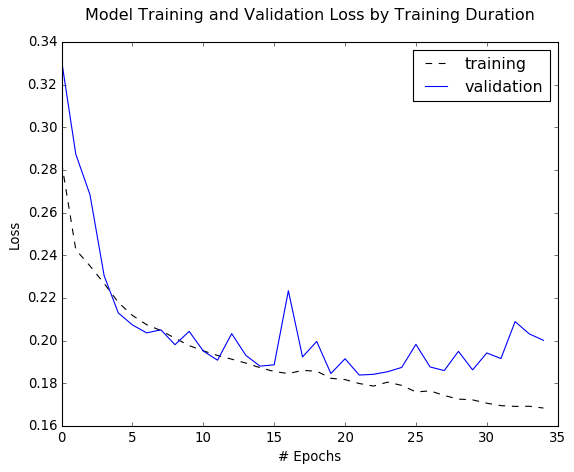

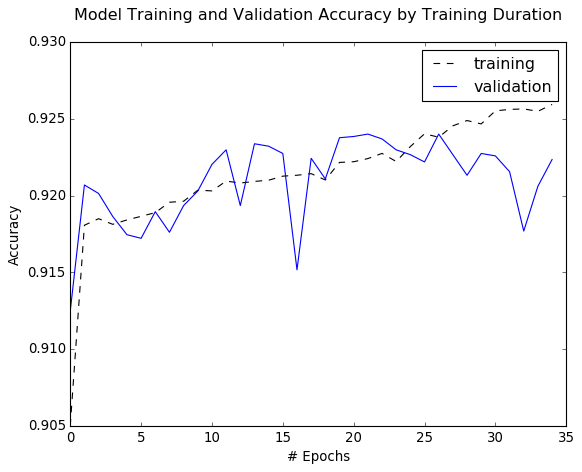

In [19]:
print(hist.history.keys())
# plot history
from matplotlib import pyplot

plt.style.use('classic')
plt.figure(2).patch.set_facecolor('white')
pyplot.plot(hist.history['loss'], 'k--',label='training')
pyplot.plot(hist.history['val_loss'], label='validation')
pyplot.legend()
pyplot.xlabel('# Epochs')
pyplot.ylabel('Loss')
pyplot.title("Model Training and Validation Loss by Training Duration", pad = 20)
pyplot.savefig('training_loss_LOOCV50.png')
pyplot.show()


plt.style.use('classic')
plt.figure(2).patch.set_facecolor('white')
pyplot.plot(hist.history['accuracy'], 'k--',label='training')
pyplot.plot(hist.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.xlabel('# Epochs')
pyplot.ylabel('Accuracy')
pyplot.title("Model Training and Validation Accuracy by Training Duration", pad = 20)
pyplot.savefig('training_acc_LOOCV50.png')
pyplot.show()

### Build Test Set

In [20]:
data_frac_tst = PTNdata1[PTNdata1['Student ID'] <= 4].iloc[:,3:-3]/maneuverMIF #define test set and convert to fraction over individual mifs
data_frac_tst = data_frac_tst.replace(np.nan,np.float64(0))
data_frac_tst.head()

#create input list of lists containing scores up to and at each particular training Exercise 
#dont include last record because there is no target variable definable for last record per student
seq_lst_ins_tst = [data_frac_tst.iloc[0:i].values.tolist() for i in range(1,len(data_frac_tst.index))]

#pad sequences using pre-sequence truncation
#when over 50 training Exercises are in memory bank, remove earliest timesteps from the beginning of sequences
padded_seq_ins_tst = pad_sequences(seq_lst_ins_tst, padding='pre',dtype='float32',maxlen = seq_length)
#print('shape of inputs',padded_seq_ins_trn.shape)

#create target for recommendations
seq_lst_tgt_tst = np.array([data_frac_tst.iloc[i+1] for i in range(0,len(data_frac_tst.index)-1)])
#print('shape of target',seq_lst_tgt_trn.shape)

#convert array to list
seq_lst_tgt_tst = [l.tolist() for l in seq_lst_tgt_tst]

#convert all maneuvers to perform or not in boolean
#0 means do not perform
#1 means perform
seq_lst_tgt_tst = convertBoolean(seq_lst_tgt_tst)

#convert back to an array
seq_lst_tgt_tst = np.asarray(seq_lst_tgt_tst)

### Look at training and testing results

In [21]:
#report training evaluation
train_eval = model.evaluate(padded_seq_ins_trn,seq_lst_tgt_trn)
print('Training Loss:',train_eval[0])
print('Training Accuracy:',train_eval[1]) 

#loss is telling me how off my predictions were. the model is giving me a probability of occurence for each graded event. 0 means it wont occur and 1 means it will occur. 
#Model is being trained on sets of binary values depicting whether or not events occured. lowest loss represents the point in training when the model had the least distance between predicted probability of occurance and occurance. 
#loss is basically like model confidence. if there is a high loss(closer to 0.5) that means the model has low confidence in its decision. If this model is intended to be used as a tool for instructor pilots, this is not as imporant because an
#IP will have the ability to adjust the recommendation. But if this tool is designed to be used on its own, log loss would be a more important metric to use. 

#accuracy is saying what percentage of the data is being classified correctly. this means being classified as occuring or not correctly. 

#report validation evaluation
val_eval = model.evaluate(padded_seq_ins_val,seq_lst_tgt_val)
print('Validation Loss:',val_eval[0])
print('Validation Accuracy:',val_eval[1])         


#report test evaluation
test_eval = model.evaluate(padded_seq_ins_tst,seq_lst_tgt_tst)
print('Testing Loss:',test_eval[0])
print('Testing Accuracy:',test_eval[1])  

1066/1066 [==============================] - 1s 705us/step
Training Loss: 0.3198064022730707
Training Accuracy: 0.9180566668510437
99/99 [==============================] - 0s 1ms/step
Validation Loss: 0.1846140684051947
Validation Accuracy: 0.923768937587738
334/334 [==============================] - 0s 790us/step
Testing Loss: 0.22382564476864067
Testing Accuracy: 0.9142963886260986


### TEST MODEL FIT to look at accuracy over time. 

### Import Data

In [22]:
PTNdata_masterPath = ('/Users/nickcforrest/Documents/My Documents/Education/AFIT/AFIT WORK/Course Work/Thesis Work/Python Files/PTNdata1_master.csv')
PTNdata_master = pd.read_csv(PTNdata_masterPath).iloc[0:, 1:]
PTNdata_master.head()

,Student ID,Training Date,Mission Analysis/Products,Ground Ops,Takeoff,Departure,Basic Aircraft Control,Cross-Check,Enroute Descent / Recovery,Inflight Checks,...,Single Engine Approach,Single Engine GA/Missed Appch,A/R Overrun,A/R Breakaway,FD/AP Operations,FMS Operations,Device,Training Exercise,Total MIF,FPS
0,1,2018-04-02,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,S,1,36,44.25
1,1,2018-04-03,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,S,2,49,57.75
2,1,2018-04-04,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,F,3,57,67.50
3,1,2018-04-06,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,S,4,71,78.25
4,1,2018-04-06,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,S,5,72,79.00


In [23]:
numManeuvers  = PTNdata_master.iloc[:,2:-4].shape[1]
numManeuvers

128

##### Categories Seen and Categories MIF Lists

In [24]:
#put maneuvers into categories
basicManeuverNames = ['Mission Analysis/Products', 'Ground Ops','Takeoff','Departure','Basic Aircraft Control','Cross-Check','Enroute Descent / Recovery','Inflight Checks','Inflight Planning','Clearing / Visual Lookout','Communication','Risk Mgmt / Decision Making','Situational Awareness','Task Management','Emergency Procedures','General Knowledge']
patternsNames = ['Overhead/Closed Pattern', 'Visual St-In', 'Landing', 'No-Flap Landing', 'Go-Around', 'Emergency Landing Pattern']
contactNames = ['G-Awareness', 'TP Stalls', 'Slow Flight', 'Power On Stalls', 'Contact Recoveries', 'Spin Recovery', 'Aileron Roll', 'Barrel Roll', 'Pitchback / Sliceback', 'Cloverleaf', 'Cuban Eight', 'Immelmann', 'Lazy Eight', 'Loop', 'Split S']
instrumentNames =['Vertical S', 'Unusual Attitudes', 'Steep Turns', 'Intercept / Maintain Arc', 'Fix to Fix', 'Holding', 'Full Procedure Approach', 'Non-Precision Final', 'Precision Final', 'Circling Approach', 'Missed Approach', 'Night Landing']
basicFormationNames = ['Wing Takeoff', 'Interval Takeoff', 'Instrument Trail', 'G-Warmup / Awareness', 'Lead Platform', 'Pitchout (Both)', 'Fingertip (Wing)', 'Route (Wing)', 'Fighting Wing (Wing)', 'Straight Ahead Rejoin', 'Turning Rejoin', 'Overshoot', 'Echelon (Wing)', 'Breakout (Wing)', 'Lost Wingman (Both)', 'Extended Trail (Wing)', 'Position Change', 'Formation Approach (Both)', 'Formation Landing (Both)', 'Battle Damage Check', 'Flt Integrity / Wingman Consideration']
tacticalFormationNames =['Delay 90', 'Delay 45', 'Hook Turn', 'Shackle', 'Cross Turn', 'Fluid Turn', 'Tactical Rejoins', 'Fluid Maneuvering', 'Tac Initial']
lowLevelNames = ['Course Mx', 'Course Entry', 'Time Control', 'Altitude Control', 'Checkpoint ID', 'LL GPS Integration', 'Tactical Maneuvering', 'LL Lead Change']
fourShipFormationNames = ['Four Ship Admin', 'Fluid 4', 'Box Formation', 'Offset Box', 'Wall', '4-Ship Fingertip','4-Ship Straight Ahead Rejoin','4-Ship Turning Rejoin']
cafIntroNames = ['Heat to Guns Setup', 'Heat to Guns Maneuvering ', 'Fuel Awareness/Management', 'Advanced Handling', 'Perch Setups', 'Maneuver Selection', 'Offensive Fighter Mnvr Exec', 'Defensive Fighter Mnvr Exec', 'CZ Recognition', 'Air to Air Weapons Employ', 'HA Lead Turn Exercise', 'HA Butterfly Setups', 'HA BFM Flt Analysis', 'SA Conventional Range', 'SA Tactical Range Proc', 'SA Safe-Excape Maneuver', 'SA Threat Reaction', 'SA Weapons Employment', 'Air to Ground Error Analysis', 'TACS/JFIRE Procedures', 'Air to Gnd 2-Ship Mutual Supt']
mafIntroNames = ['Mission Management', 'VFR Arrival', 'Tanker Procedures', 'Reciever Procedures', 'Airdrop Procedures', 'Crew Coordination', 'Single Engine Approach', 'Single Engine GA/Missed Appch', 'A/R Overrun', 'A/R Breakaway', 'FD/AP Operations', 'FMS Operations']

In [25]:
#list categories of flight maneuvers
categoryList = ['basicManeuver','patterns','contact','instrument','basicFormation','tacticalFormation','lowLevel','fourShipFormation','cafIntro','mafIntro']

##### Make scores a fraction of individual MIF for each maneuver to more appropriately track progress

In [26]:
#list of mifs in order
maneuverMIF = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,3,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,3,3,4,4,4,4,4,3,4,4,4,3,3,4,4,4,4,4,4,4,3,4,3,3,3,3,4,3]

#make df to reference 
maneuverMIF_df = pd.DataFrame([PTNdata_master.iloc[:,2:-4].columns,maneuverMIF])
maneuverMIF_df.columns = maneuverMIF_df.iloc[0]
maneuverMIF_df.drop(maneuverMIF_df.index[0],inplace=True)
#maneuverMIF_df


In [27]:
#false means you already have this data 
#True means you want to build this data
ALL_MIF_RATIOS = False

In [ ]:
#convert to fraction over individual mifs
if ALL_MIF_RATIOS:
    PTNdata = PTNdata_master
    PTNdata.iloc[:,2:-4] = PTNdata_master.iloc[:,2:-4]/maneuverMIF
    PTNdata.head()
else: 
    PTNdata_mifPath = ('/Users/nickcforrest/Documents/My Documents/Education/AFIT/AFIT WORK/Course Work/Thesis Work/Python Files/PTNdata1_mif.csv')
    PTNdata = pd.read_csv(PTNdata_mifPath).iloc[0:, 1:]
    


### User's MIF Ratio List and Category Progress From All Grades Before The Requested Training Event 

### Import Deep Learning Packages

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#load model from ModelTraining_PTNdata1 file 
model = load_model('Model_LOOCV_50.h5')

In [ ]:
#define function that rounds raw estimations into binary outputs
split_thresh = 0.5
def toBoolean(mylist):
    l = [[1 if y > split_thresh else 0 for y in x] for i,x in enumerate(mylist)]
    return l

### Apply LSTM Model for Recommendations

In [ ]:
#number of students that we are testing on
numUsers = 4

event_per_student = PTNdata1[PTNdata1['Student ID'] <= 4]['Student ID'].value_counts()
print(event_per_student)
maxEvents = event_per_student.max()
print(maxEvents)

#create 4 empty lists for all accuracies to be stored. 
accList = [[None]*(maxEvents-1) for _ in range(4)]

row = 0
col = 0

1    93
3    86
4    79
2    77
Name: Student ID, dtype: int64
93


In [ ]:
#create list of accuracies per training exercise per student

for userID in range(1,5): 
    row = userID - 1
    for TE in range(1,event_per_student[userID]):
        col = TE - 1
        timeList =[]

        #populate ip recomendation
        ip_recom = [1 if x>0 else 0 for x in PTNdata_master[(PTNdata_master['Student ID'] == userID) & (PTNdata_master['Training Exercise'] == TE)].iloc[0,2:-4].values]
        
        #define start time of recommedenation
        recommendTime_start = timeit.default_timer()

        #user's data so far
        userData = PTNdata[PTNdata['Student ID']== userID].iloc[0:TE,2:-4]

        #create input list of lists containing scores up to and at each particular training event 
        #dont include last record because there is no target variable definable for last record per student
        userInput_raw = [userData.values.tolist()]

        #pad sequences using pre-sequence truncation
        #when over seq_length training events are in memory bank, remove earliest timesteps from the beginning of sequences
        userInput = pad_sequences(userInput_raw[-seq_length:], padding='pre',dtype='float32',maxlen = seq_length)

        #make raw prediction
        pred = model.predict(userInput, verbose=0)

        #round prediction to recomendation
        recom = toBoolean(pred)[0]

        #calculate final time for individual recomendation 
        recommendTime = timeit.default_timer() - recommendTime_start
        timeList.append(recommendTime)
        #print('Time to generate recomendation', recommendTime, ' seconds')

        #ADD CODE TO CALCULATE BINARY CROSS ENTROPY OF EACH. THEN KEEP TRACK OF THOSE THINGS OVER TIME. 


        #Calculate percentage of matching elements between ip_recom and recom when order matters
        acc = sum([True if i == j else False for i,j in zip(recom, ip_recom)])/numManeuvers

        #add accuracy to list of accuracies
        accList[row][col] = acc
    
#print(accList)

In [ ]:
#flatten into 1D list and then get rid of None values
allAcc = [i for i in [j for sub in accList for j in sub] if i]
avgAcc = np.mean(allAcc)
print(avgAcc)

0.9178389350453172


In [ ]:
#zips lists together
#sums values at each TE excluding Nones
#divides the sum by the number of values that werent nones, to get averages on each TE

#average Accuracy by training Event
avgAccByTE = [sum(filter(None, x))/(sum(l is not None for l in x)) for x in zip(*accList)]

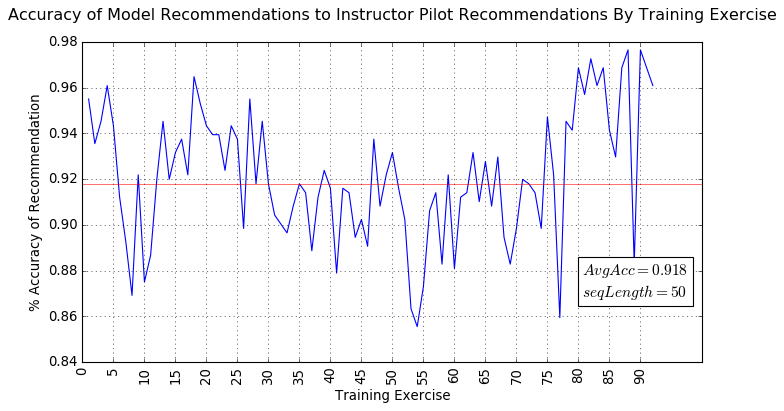

In [ ]:
ModelResultsByTE = plt.figure(num=2, figsize=(10, 5), dpi=80)
plt.style.use('classic')
plt.figure(2).patch.set_facecolor('white')
plt.gca().set_facecolor('xkcd:white')
plt.plot(np.arange(1,len(avgAccByTE)+1,1),avgAccByTE)
plt.xticks(np.arange(0, len(avgAccByTE) +1 , 5.0),rotation = 90)

avgline = plt.axhline(y= avgAcc, color='red', linestyle='-', lw=.5, label = 'Avg Accuracy')

plt.xlabel("Training Exercise")
plt.ylabel('% Accuracy of Recommendation')
plt.grid()
plt.title("Accuracy of Model Recommendations to Instructor Pilot Recommendations By Training Exercise", pad = 20)


textstr = '\n'.join((
    r'$AvgAcc=%.3f$' % (avgAcc, ),
    r'$seqLength=%.2s$' % (seq_length, )))


# these are matplotlib.patch.Patch properties
props = dict( facecolor='white', alpha=1)

# place a text box in upper left in axes coords
ModelResultsByTE.text(0.75, 0.35, textstr, fontsize=14,
        verticalalignment='top', bbox=props)


#layer, seq length, epochs
holder = 'ModelResultsByTE_LOOCV%s' %seq_length
plt.savefig('%s.png' % holder)

plt.show()